In [21]:
#MNIST Classification
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
batch_size = 12

train_data = datasets.MNIST('./datasets', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST('./datasets', train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

print(len(train_data))
print(len(test_data))

60000
10000


In [23]:
# Model #1
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.in_dim = 28*28
        self.out_dim = 10
        
        self.fc1 = nn.Linear(self.in_dim, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 10)
        self.fc4 = nn.Linear(10, self.out_dim)

    def forward(self, x):
        x = F.tanh(self.fc1(x.view(-1, self.in_dim)))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
    
        return x

In [24]:
#Training Dataset Using Model #1
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        model.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if(i + 1) % 2500 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2500))
            running_loss = 0.0
            
print('Finished Training')

[1,  2500] loss: 1.324
[1,  5000] loss: 0.479
[2,  2500] loss: 0.338
[2,  5000] loss: 0.277
[3,  2500] loss: 0.231
[3,  5000] loss: 0.214
[4,  2500] loss: 0.182
[4,  5000] loss: 0.176
[5,  2500] loss: 0.159
[5,  5000] loss: 0.150
Finished Training


In [25]:
#Testing 10,000 Data from Dataset
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()
    
print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict:.3f}")

9482/10000
Accuracy: 0.948


## Save weight and bias

In [26]:
size = [784, 30, 30, 10, 10] # Set your DNN configuration
weights = []
biases = []
for i_layer in range(len(size)-1):
    weights.append([w.tolist() for w in list(model.parameters())[i_layer*2]]) # even index number: weights
    biases.append([[b.tolist()] for b in list(model.parameters())[i_layer*2+1]]) # odd index number: biases

In [27]:
import json
f=open("WeightsAndBiases.txt", "w")
data = {"sizes": size,
        "weights": weights,
        "biases": biases,
        "cost": "CrossEntropyCost"}
json.dump(data, f)
f.close()

### Plot histogram

24820
80
max:  1.559559941291809
min:  -1.551759123802185


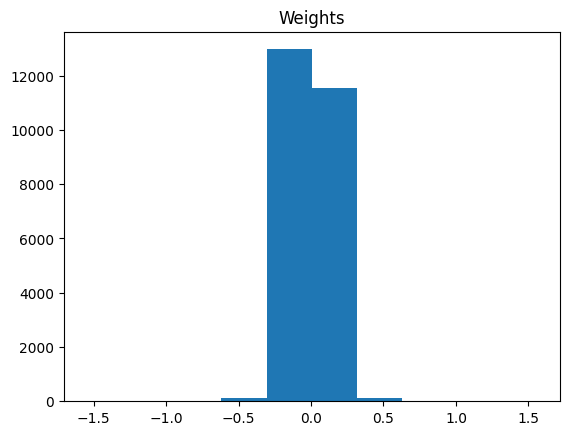

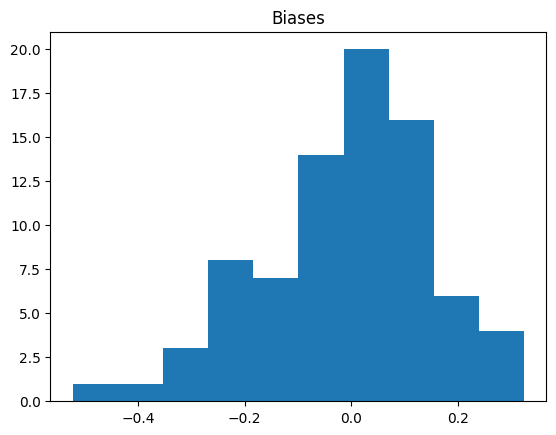

In [28]:
import matplotlib.pyplot as plt
weights_flat=[]
biases_flat=[]
for i_layer in range(len(size)-1):
    w=[w.tolist() for w in list(model.parameters())[i_layer*2]]
    b=[b.tolist() for b in list(model.parameters())[i_layer*2+1]]
    biases_flat += b
    for k in range(len(w)):
        weights_flat += w[k]
plt.figure()
plt.title("Weights")
plt.hist(weights_flat);
plt.figure()
plt.title("Biases")
plt.hist(biases_flat);
print(len(weights_flat))
print(len(biases_flat))
print("max: ", max(weights_flat))
print("min: ", min(weights_flat))

## Write Verilog mif

In [9]:
import os
os.makedirs("./w_b")

In [29]:
import json
dataWidth = 16
dataIntWidth = 1
weightIntWidth = 4
inputFile = "WeightsAndBiases.txt"
#dataFracWidth = dataWidth-dataIntWidth
weightFracWidth = dataWidth-weightIntWidth
#biasIntWidth = dataIntWidth+weightIntWidth
biasIntWidth = weightIntWidth
biasFracWidth = dataWidth-biasIntWidth
outputPath = "./w_b/"
headerPath = "./"

def DtoB(num,dataWidth,fracBits):                        #funtion for converting into two's complement format
    if num >= 0:
        num = num * (2**fracBits)
        #num = int(num)
        num = round(num)
        d = num
    else:
        num = -num
        num = num * (2**fracBits)        #number of fractional bits
        #num = int(num)
        num = round(num)
        if num == 0:
            d = 0
        else:
            d = 2**dataWidth - num
    return d

def genWaitAndBias(dataWidth,weightFracWidth,biasFracWidth,inputFile):
    weightIntWidth = dataWidth-weightFracWidth
    biasIntWidth = dataWidth-biasFracWidth
    myDataFile = open(inputFile,"r")
    weightHeaderFile = open(headerPath+"weightValues.h","w")
    myData = myDataFile.read()
    myDict = json.loads(myData)
    myWeights = myDict['weights']
    myBiases = myDict['biases']
    weightHeaderFile.write("int weightValues[]={")
    for layer in range(0,len(myWeights)):
        for neuron in range(0,len(myWeights[layer])):
            fi = 'w_'+str(layer+1)+'_'+str(neuron)+'.mif'
            f = open(outputPath+fi,'w')
            for weight in range(0,len(myWeights[layer][neuron])):
                if 'e' in str(myWeights[layer][neuron][weight]):
                    p = '0'
                else:
                    if myWeights[layer][neuron][weight] > 2**(weightIntWidth-1):
                        myWeights[layer][neuron][weight] = 2**(weightIntWidth-1)-2**(-weightFracWidth)
                        print("overflow happens")
                        exit(0)
                    elif myWeights[layer][neuron][weight] < -2**(weightIntWidth-1):
                        myWeights[layer][neuron][weight] = -2**(weightIntWidth-1)
                        print("overflow happens")
                        exit(0)
                    wInDec = DtoB(myWeights[layer][neuron][weight],dataWidth,weightFracWidth)
                    p = bin(wInDec)[2:]
                f.write(p+'\n')
                weightHeaderFile.write(str(wInDec)+',')
            f.close()
    weightHeaderFile.write('0};\n')
    weightHeaderFile.close()
    
    biasHeaderFile = open(headerPath+"biasValues.h","w")
    biasHeaderFile.write("int biasValues[]={")
    for layer in range(0,len(myBiases)):
        for neuron in range(0,len(myBiases[layer])):
            fi = 'b_'+str(layer+1)+'_'+str(neuron)+'.mif'
            p = myBiases[layer][neuron][0]
            if 'e' in str(p): #To remove very small values with exponents
                res = '0'
            else:
                if p > 2**(biasIntWidth-1):
                    p = 2**(biasIntWidth-1)-2**(-biasFracWidth)
                elif p < -2**(biasIntWidth-1):
                    p = -2**(biasIntWidth-1)
                bInDec = DtoB(p,dataWidth,biasFracWidth)
                res = bin(bInDec)[2:]
            f = open(outputPath+fi,'w')
            f.write(res)
            biasHeaderFile.write(str(bInDec)+',')
            f.close()
    biasHeaderFile.write('0};\n')
    biasHeaderFile.close()
            
if __name__ == "__main__":
    genWaitAndBias(dataWidth,weightFracWidth,biasFracWidth,inputFile)